In [472]:
import tensorflow as tf
import numpy as np
import cv2
import base64
import io
import json
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.layers import Dense, Reshape, Input, BatchNormalization
from tensorflow.data import Dataset
from PIL import Image
from keras.models import load_model

from plt_fn import show_images

IMAGE_SHAPE = (70,70)
batch_size = 64
tf.random.set_seed(10)
l2_lambda = 0.0001 

In [474]:
def preprocessing_fun(img):
    img = img.astype(np.uint8)
    
    border = 160
        
    ret,thresh = cv2.threshold(img,border,255,cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    erode = cv2.erode(thresh, kernel, iterations = 2)
    img = cv2.bitwise_or(img, erode)
    

    gray = 255*(img < border).astype(np.uint8)
    coords = cv2.findNonZero(gray)
    x, y, w, h = cv2.boundingRect(coords)
    rect = img[y:y+h, x:x+w]
    
    img = cv2.copyMakeBorder(rect,1,1,1,1,cv2.BORDER_CONSTANT,value=255)
    img = cv2.resize(img, IMAGE_SHAPE, interpolation = cv2.INTER_NEAREST)
    
#     ret,thresh = cv2.threshold(img,220,255,cv2.THRESH_BINARY)
#     kernel = np.ones((2, 2), np.uint8)
#     erode = cv2.erode(thresh, kernel, iterations = 1)
#     img = cv2.bitwise_or(erode,img)
    
    img = np.where(img > 80, img - 70, img)
    img = np.where(img < 0, 0, img)
    img = img.reshape(*IMAGE_SHAPE,1)
    
    return img

In [475]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    preprocessing_function = preprocessing_fun,
    validation_split=0.25
)

In [476]:
training_gen = img_datagen.flow_from_directory(
    'TRAIN',
    target_size=IMAGE_SHAPE,
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=True,
    seed=10,
    subset="training"
)
validation_gen = img_datagen.flow_from_directory(
    'TRAIN',
    target_size=IMAGE_SHAPE,
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=True,
    seed=10,
    subset="validation"
)

Found 12022 images belonging to 33 classes.
Found 3992 images belonging to 33 classes.


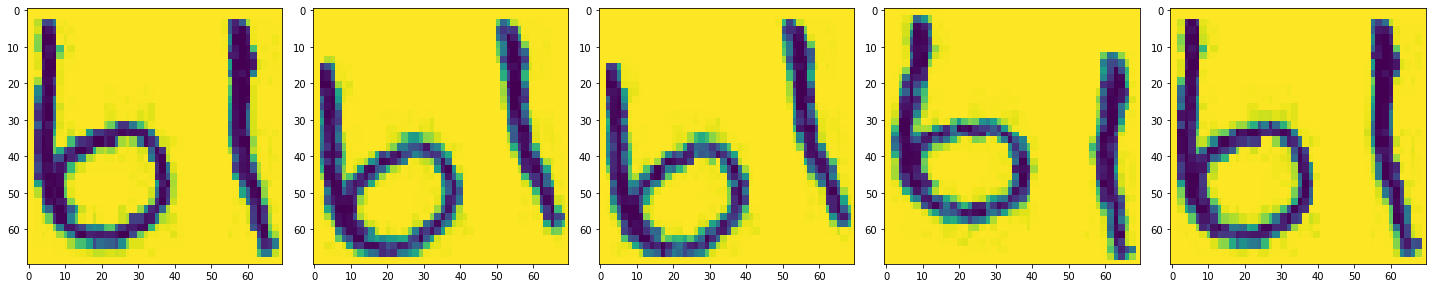

In [477]:
augmented_images = [training_gen[0][0][0] for i in range(5)]

fig, axes = plt.subplots(1, 5, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip( augmented_images, axes):
        ax.imshow(img.astype('uint8'))
plt.tight_layout()
plt.show()

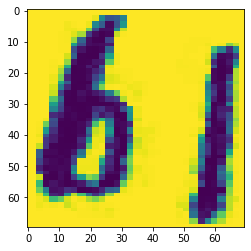

In [478]:
# print(training_gen[1][0][0])
plt.imshow(training_gen[1][0][0].astype("uint8"))

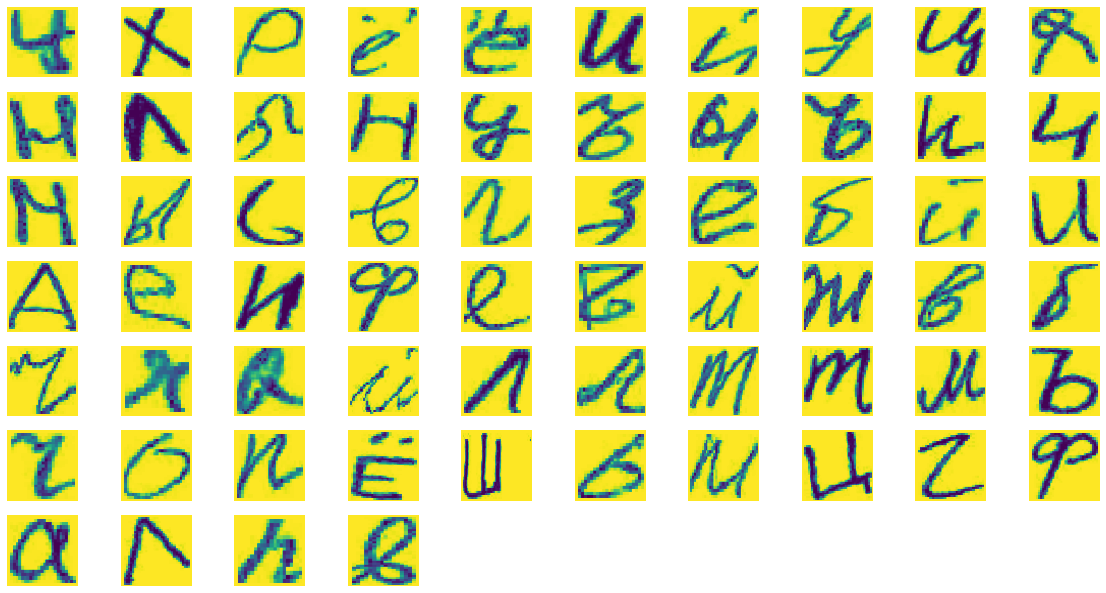

In [480]:
plt.figure(figsize=(20, 20))
def show_images(train_ds, class_names, n = 9):
    images, labels = train_ds[2]
    for i in range(64):
        ax = plt.subplot(13, 10, i + 1)
        plt.imshow(images[i].astype("uint8"))
#         plt.title(class_names[labels[i]])
        plt.axis("off")
show_images(training_gen, np.array(set(training_gen.labels)))

In [442]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(*IMAGE_SHAPE, 1))
]

In [443]:
def conv_2d_pooling_layers(filters, drop_prob):
    return [
        tf.keras.layers.Conv2D(
            filters,
            (3,3),
            activation='relu',
            padding='same'
        ),
#         tf.keras.layers.BatchNormalization(axis=1),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(drop_prob),
    ]
core_layers = \
    conv_2d_pooling_layers(32, 0.25) + \
    conv_2d_pooling_layers(64, 0.25) + \
    conv_2d_pooling_layers(128, 0.5)

In [444]:
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, kernel_initializer='he_uniform', 
                          activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
    tf.keras.layers.BatchNormalization(axis=1),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(33, kernel_initializer='glorot_uniform', activation='softmax')
]

In [445]:
model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 70, 70, 1)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 70, 70, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 35, 35, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 35, 35, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 17, 17, 64)       0         
 g2D)                                                 

In [446]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

In [493]:
history = model.fit(
    training_gen,
    steps_per_epoch=int(np.ceil(training_gen.n / float(batch_size))),
    validation_data = validation_gen,
    validation_steps=int(np.ceil(validation_gen.n / float(batch_size))),
    epochs = 30,
#     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/30
188/188 [==============================] - 38s 203ms/step - loss: 0.6537 - accuracy: 0.9289 - val_loss: 0.7358 - val_accuracy: 0.9131
Epoch 2/30
188/188 [==============================] - 35s 187ms/step - loss: 0.6243 - accuracy: 0.9339 - val_loss: 0.7191 - val_accuracy: 0.9156
Epoch 3/30
188/188 [==============================] - 33s 176ms/step - loss: 0.6494 - accuracy: 0.9311 - val_loss: 0.7157 - val_accuracy: 0.9186
Epoch 4/30
188/188 [==============================] - 34s 180ms/step - loss: 0.6309 - accuracy: 0.9360 - val_loss: 0.7459 - val_accuracy: 0.9118
Epoch 5/30
188/188 [==============================] - 35s 186ms/step - loss: 0.6220 - accuracy: 0.9403 - val_loss: 0.7326 - val_accuracy: 0.9128
Epoch 6/30
188/188 [==============================] - 34s 182ms/step - loss: 0.6432 - accuracy: 0.9326 - val_loss: 0.7214 - val_accuracy: 0.9101
Epoch 7/30
188/188 [==============================] - 34s 179ms/step - loss: 0.6384 - accuracy: 0.9330 - val_loss: 0.7267 - val_ac

In [494]:
model.evaluate(validation_gen)

63/63 [==============================] - 3s 48ms/step - loss: 0.6978 - accuracy: 0.9196


[0.6977551579475403, 0.9195891618728638]

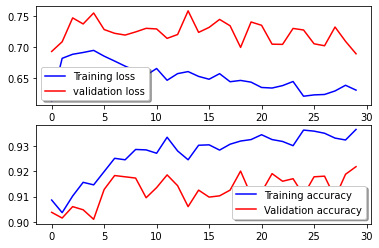

In [483]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [519]:
model.save('weight/20-epoch')

INFO:tensorflow:Assets written to: weight/20-epoch/assets


In [513]:
from math import ceil
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

def predict_file(namefile, y):
    labels = ['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']

    with open(namefile) as json_file:
        data = json.load(json_file)
        data = data["response"]["data"]

        predicted_labels = []
        imgs = [] 
        imgs_preprocessing = [] 
        for hash in data:
                img = base64.b64decode(data[hash])
                img = Image.open(io.BytesIO(img))
                img = np.array(img)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.uint8)
                imgs.append(img)
                imgs_preprocessing.append(preprocessing_fun(img))
        
        y_pred = model.predict(np.array(imgs_preprocessing))

        plt.figure(figsize=(20, 20))
        
        count = 0
        for i, p in enumerate(y_pred): 
            ind = np.argmax(p)
            if (not y_right[i] == labels[ind]):
#                 ax = plt.subplot(10, 10, i + 1)
#                 plt.imshow(imgs[i].astype("uint8"))
#                 plt.axis("off")
                ax = plt.subplot(10, 20, 2*count+1)
                plt.imshow(imgs[i].astype("uint8"))
                plt.axis("off")
                ax = plt.subplot(10, 20, 2*count+2)
                plt.imshow(imgs_preprocessing[i].astype("uint8"))
                plt.axis("off")
                plt.title(labels[ind] + ' ' + y_right[i])
                count = count + 1
        print("acc", 1 - count / len(y))
        print("wrong", count)
        return count

acc 0.89
wrong 11


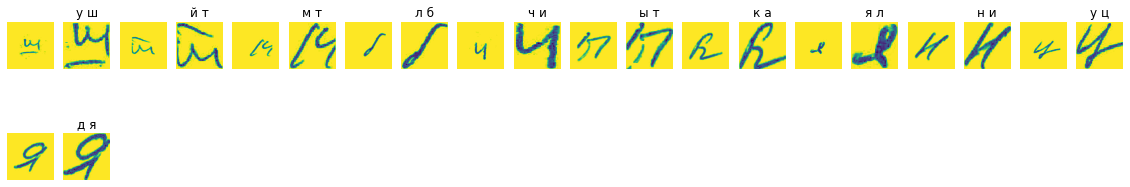

In [521]:
y_right = [
    'ц', 'н', 'ъ', 'о', 'п', 'ь', 'ж', 'ц', 'м', 'в',
    'э', 'к', 'ш', 'ж', 'ю', 'ь', 'й', 'д', 'е', 'х',
    'т', 'з', 'д', 'т', 'у', 'х', 'б', 'ж', 'ь', 'ь',
    'а', 'ъ', 'и', 'ь', 'к', 'х', 'т', 'р', 'б', 'ш',
    'и', 'д', 'ж', 'м', 'ц', 'ё', 'я', 'р', 'е', 'й',
    
    'и', 'е', 'а', 'с', 'л', 'э', 'ц', 'ъ', 'л', 'с',
    'ю', 'п', 'ж', 'ш', 'р', 'х', 'ш', 'и', 'л', 'ч',
    'и', 'й', 'м', 'а', 'т', 'в', 'б', 'д', 'х', 'т',
    'т', 'л', 'щ', 'ё', 'ц', 'м', 'р', 'с', 'я', 'г',
    'ю', 'ц', 'у', 'и', 'х', 'ё', 'е', 'я', 'а', 'ч',
]
count1 = predict_file('json/1.json', y_right)

acc 0.89
wrong 11


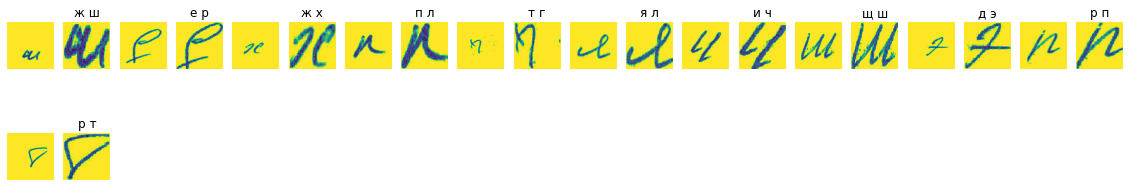

In [526]:
y_right = [
    'х', 'ш', 'у', 'ё', 'д', 'р', 'ь', 'ф', 'ф', 'р',
    'р', 'о', 'в', 'х', 'л', 'ж', 'ь', 'г', 'д', 'л',
    'ч', 'у', 'ш', 'о', 'г', 'к', 'л', 'ю', 'ц', 'ю',
    'е', 'к', 'о', 'щ', 'п', 'ъ', 'ч', 'п', 'ш', 'ф',
    'ю', 'о', 'с', 'ж', 'л', 'ф', 'м', 'э', 'л', 'ж',
    
    'б', 'ю', 'н', 'ц', 'ж', 'у', 'к', 'ю', 'п', 'щ',
    'г', 'ф', 'н', 'ю', 'щ', 'й', 'ё', 'ж', 'б', 'т',
    'л', 'у', 'ъ', 'ю', 'у', 'к', 'ы', 'э', 'с', 'ъ',
    'ш', 'и', 'в', 'в', 'о', 'м', 'с', 'я', 'ы', 'ю',
    'ы', 'ю', 'ы', 'н', 'в', 'ш', 'л', 'п', 'ь', 'м',
]
count2 = predict_file('json/json_0.json', y_right)

acc 0.92
wrong 8


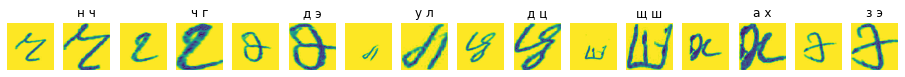

In [516]:
y_right = [
    'а', 'л', 'ч', 'л', 'н', 'к', 'ц', 'с', 'и', 'ч',
    'х', 'ч', 'а', 'х', 'г', 'г', 'у', 'р', 'о', 'а',
    'ю', 'з', 'д', 'ф', 'п', 'ч', 'е', 'а', 'т', 'о',
    'э', 'а', 'о', 'р', 'ц', 'ь', 'у', 'й', 'ж', 'л',
    'ц', 'а', 'ж', 'м', 'у', 'ю', 'р', 'у', 'э', 'т',
    
    'й', 'з', 'б', 'ж', 'т', 'п', 'й', 'с', 'х', 'ч',
    'ч', 'б', 'н', 'у', 'о', 'н', 'п', 'р', 'ш', 'л',
    'а', 'м', 'р', 'ь', 'ю', 'г', 'х', 'д', 'к', 'н',
    'б', 'э', 'м', 'щ', 'ч', 'р', 'ы', 'к', 'а', 'д',
    'б', 'з', 'к', 'б', 'ж', 'ы', 'я', 'э', 'ю', 'й',
]
count3 = predict_file('json/json_1.json', y_right)

acc 0.86
wrong 14


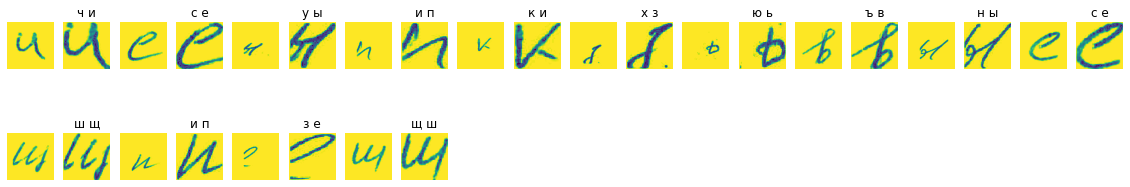

In [517]:
y_right = [
    'г', 'с', 'ь', 'ы', 'и', 'п', 'а', 'ё', 'е', 'н',
    'ф', 'у', 'к', 'ш', 'ы', 'и', 'а', 'к', 'и', 'р',
    'л', 'м', 'с', 'с', 'и', 'у', 'ъ', 'п', 'г', 'г',
    'ь', 'б', 'ч', 'щ', 'ё', 'о', 'и', 'в', 'х', 'а',
    'ч', 'ж', 'ф', 'е', 'т', 'и', 'ё', 'с', 'ы', 'п',
    
    'ё', 'д', 'з', 'е', 'ч', 'д', 'ь', 'р', 'н', 'п',
    'ь', 'л', 'й', 'й', 'я', 'п', 'э', 'в', 'и', 'к',
    'ы', 'ш', 'щ', 'е', 'щ', 'щ', 'ф', 'п', 'г', 'в',
    'е', 'д', 'у', 'м', 'о', 'ы', 'ш', 'ъ', 'с', 'ч',
    'ш', 'в', 'й', 'и', 'ж', 'щ', 'ж', 'п', 'о', 'о',
]
count4 = predict_file('json/json_2.json', y_right)

acc 0.91
wrong 9


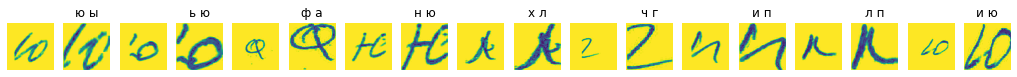

In [518]:
y_right = [
    'т', 'ц', 'щ', 'щ', 'п', 'м', 'д', 'о', 'б', 'м',
    'щ', 'я', 'у', 'к', 'ы', 'ъ', 'ю', 'а', 'о', 'б',
    'у', 'а', 'й', 'з', 'ь', 'л', 'ч', 'в', 'д', 'с',
    'в', 'е', 'ч', 'ю', 'л', 'т', 'п', 'ч', 'р', 'ю',
    'и', 'л', 'и', 'д', 'р', 'и', 'б', 'е', 'ь', 'в',
    
    'л', 'й', 'ё', 'е', 'щ', 'ш', 'л', 'г', 'н', 'у',
    'ь', 'д', 'ю', 'п', 'ж', 'ъ', 'ш', 'п', 'к', 'п',
    'э', 'ы', 'п', 'я', 'й', 'ъ', 'щ', 'д', 'ъ', 'з',
    'м', 'е', 'з', 'м', 'а', 'ю', 'х', 'ш', 'ф', 'ь',
    'л', 'х', 'щ', 'е', 'г', 'д', 'р', 'у', 'ш', 'б',
]
count5 = predict_file('json/json_3.json', y_right)

acc 0.9299999999999999
wrong 7


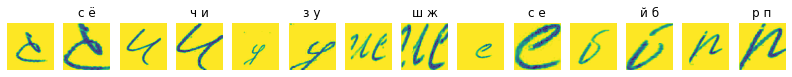

In [501]:
y_right = [
    'з', 'в', 'о', 'р', 'е', 'щ', 'с', 'ё', 'ф', 'с',
    'г', 'ы', 'р', 'з', 'б', 'ю', 'с', 'ш', 'х', 'у',
    'у', 'б', 'е', 'ф', 'и', 'д', 'ш', 'п', 'ё', 'б',
    'т', 'ж', 'б', 'й', 'л', 'п', 'а', 'ж', 'ж', 'а',
    'э', 'г', 'ь', 'ъ', 'ш', 'т', 'у', 'г', 'ч', 'д',
    
    'ь', 'щ', 'ц', 'е', 'а', 'в', 'ж', 'ь', 'ф', 'з',
    'ж', 'ч', 'ж', 'ш', 'с', 'е', 'а', 'ф', 'ы', 'ё',
    'ь', 'е', 'а', 'р', 'ь', 'ж', 'э', 'л', 'д', 'щ',
    'б', 'т', 'к', 'э', 'ю', 'г', 'ч', 'б', 'о', 'ь',
    'п', 'ь', 'к', 'м', 'в', 'ё', 'р', 'ф', 'у', 'м',
]
count6 = predict_file('json/json_4.json', y_right)

acc 0.88
wrong 12


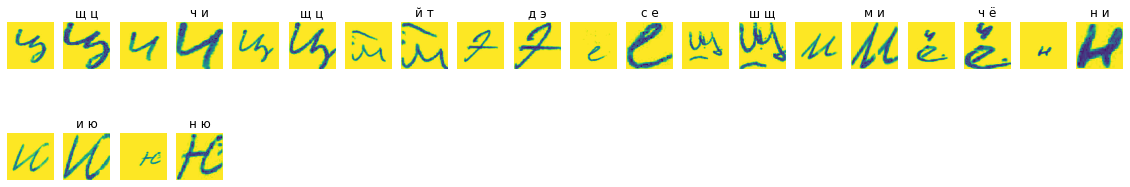

In [502]:
y_right = [
    'б', 'ю', 'р', 'ы', 'ц', 'ц', 'у', 'щ', 'и', 'ц',
    'г', 'б', 'д', 'б', 'э', 'и', 'и', 'ь', 'и', 'ч',
    'ц', 'ё', 'и', 'щ', 'у', 'у', 'ш', 'т', 'ц', 'к',
    'е', 'ю', 'о', 'ы', 'ш', 'э', 'ё', 'о', 'ч', 'н',
    'т', 'у', 'л', 'о', 'п', 'й', 'з', 'с', 'с', 'у',
    
    'ш', 'й', 'г', 'ш', 'б', 'е', 'щ', 'ф', 'о', 'п',
    'н', 'я', 'с', 'б', 'к', 'л', 'в', 'б', 'щ', 'б',
    'л', 'г', 'ч', 'я', 'м', 'и', 'п', 'у', 'з', 'я',
    'л', 'д', 'ё', 'я', 'ф', 'ь', 'й', 'и', 'ё', 'х',
    'т', 'ш', 'и', 'й', 'э', 'ю', 'с', 'ю', 'ш', 'ф',
]
count7 = predict_file('json/json_5.json', y_right)

acc 0.91
wrong 9


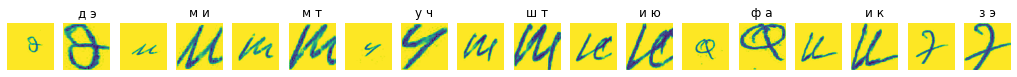

In [505]:
y_right = [
    'т', 'э', 'ь', 'ф', 'у', 'щ', 'з', 'ъ', 'м', 'э',
    'и', 'ь', 'б', 'в', 'к', 'х', 'о', 'п', 'т', 'б',
    'о', 'ы', 'у', 'с', 'з', 'т', 'с', 'м', 'э', 'п',
    'в', 'к', 'ф', 'е', 'н', 'б', 'к', 'ч', 'ё', 'с',
    'й', 'а', 'с', 'ь', 'б', 'ц', 'й', 'э', 'э', 'х',
    
    'у', 'я', 'ц', 'б', 'щ', 'у', 'е', 'д', 'й', 'ц',
    'ш', 'ё', 'к', 'о', 'т', 'я', 'щ', 'ы', 'р', 'е',
    'а', 'ю', 'х', 'й', 'э', 'ш', 'ж', 'й', 'ё', 'ы',
    'ф', 'р', 'у', 'х', 'э', 'г', 'ь', 'ц', 'ш', 'ю',
    'э', 'б', 'б', 'ж', 'а', 'к', 'е', 'т', 'э', 'ю',
]
count8 = predict_file('json/json_6.json', y_right)

In [506]:
1-(count1 + count2 + count3 + count4+ count5+ count6+ count7+count8) / 800

0.8987499999999999

In [531]:
dictionary = {}
for i in range(20):
    with open('json/json__'+ str(i) + '.json') as json_file:
        data = json.load(json_file)
        data = data["response"]["data"]
        dictionary = {**dictionary, **data}

In [543]:
labels = ['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']

predicted_labels = []
imgs = [] 
imgs_preprocessing = [] 
for hash in data:
                img = base64.b64decode(data[hash])
                img = Image.open(io.BytesIO(img))
                img = np.array(img)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.uint8)
                imgs.append(img)
                imgs_preprocessing.append(preprocessing_fun(img))
        
y_pred = model.predict(np.array(imgs_preprocessing))


In [546]:
dictionary_answer = dict.fromkeys(dictionary.keys())

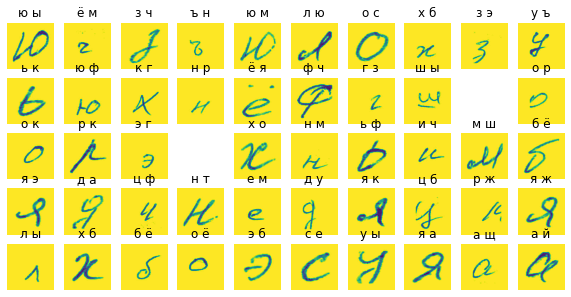

In [553]:
plt.figure(figsize=(10, 10))
y_right = [
    'ы', 'м', 'ч', 'н', 'м', 'ю', 'с', 'б', 'э', 'ъ',
    'к', 'ф', 'г', 'р', 'я', 'ч', 'з', 'ы', 'р', 'р',
    'к', 'к', 'г', 'э', 'о', 'м', 'ф', 'ч', 'ш', 'ё',
    'э', 'а', 'ф', 'т', 'м', 'у', 'к', 'б', 'ж', 'ж',
    'ы', 'б', 'ё', 'ё', 'б', 'е', 'ы', 'а', 'щ', 'й',
    
    'ю', 'ч', 'з', 'ъ', 'ю', 'л', 'о', 'х', 'з', 'у',
    'ь', 'ю', 'х', 'н', 'ё', 'ф', 'г', 'ш', '', 'р',
    'к', 'к', 'г', 'э', 'о', 'м', 'ф', 'ч', 'ш', 'ё',
    'э', 'а', 'ф', 'т', 'м', 'у', 'к', 'б', 'ж', 'ж',
    'ы', 'б', 'ё', 'ё', 'б', 'е', 'ы', 'а', 'щ', 'й',
]
count = 0
for i, p in enumerate(y_pred): 
    if i > 49:
        ind = np.argmax(p)
        if (not y_right[i] == labels[ind]):
                ax = plt.subplot(10, 10, i + 1)
                plt.imshow(imgs[i].astype("uint8"))
                plt.axis("off")
                plt.title(labels[ind] + ' ' + y_right[i])
                count = count + 1
# print("acc", 1 - count / len(dictionary))
# print("wrong", count)